In [1]:
import pandas as pd
import re
import numpy as np
import datetime
import matplotlib
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Downloaded our data and merge
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

d = pd.merge(train, features, how='left', on=['Store','Date'])
df = pd.merge(d, stores, how='left', on='Store')

# Generate week and year
df['Year'] = df['Date'].apply(lambda time: int(time[0:4]))

def week(x):
    y = int(x.split('-')[0])
    m = int(x.split('-')[1])
    d = int(x.split('-')[2])
    return int(datetime.date(y, m, d).strftime("%W"))

df['Week'] = df['Date'].apply(week)

# Sort values
df = df.sort_values(by = ['Year', 'Week', 'Store', 'Dept'])

# Created Sample Weight 
df['Sample Weight'] = df['IsHoliday_x'].apply(lambda x: 1 if x == False else 5)

# Splited data into test and training
df.index = range(0,len(df))
test_df = df[df['Year'] == 2012][df['Week'] >= 5]
train_df = df[:305981]

In [3]:
# Task 1
# Creating month and group by it
df['Year_Month'] = df['Date'].apply(lambda x: x.split('-')[0] + ' ' + x.split('-')[1])
train_df['Year_Month'] = train_df['Date'].apply(lambda x: x.split('-')[0] + ' ' + x.split('-')[1])
test_df['Year_Month'] = test_df['Date'].apply(lambda x: x.split('-')[0] + ' ' + x.split('-')[1])

gr = df.groupby(['Year_Month', 'Store']).agg({'Weekly_Sales':'sum'})

#The biggest sales in September 2011 was in 4'th store
gr.loc[('2011 09',)][gr.loc[('2011 09',)] == gr.loc[('2011 09',)].max()]
#The lowest sales in January 2011 was in 33'th store
gr.loc[('2011 01',)][gr.loc[('2011 01',)] == gr.loc[('2011 01',)].min()]

# Bigger sales in holydays in holydays (answer is 72, 77, 99)
hod = train_df.groupby(['IsHoliday_x', 'Dept']).agg({'Weekly_Sales':'mean'})

num_of_depts_plus = []
for i in hod.loc[(True)].index:
    if (float(hod.loc[(True,i)]) / float(hod.loc[(False,i)])) >= 2:
        num_of_depts_plus.append(i)
num_of_depts_plus

# Smaller sales in holidays(answer is 16, 43, 47, 56)
num_of_depts_minus = []
for i in hod.loc[(True,)].index:
    if (float(hod.loc[(True,i)]) / float(hod.loc[(False,i)])) <= 0.5:
        num_of_depts_minus.append(i)
        
# Created Department_Type 
def dep_type(x):
    if x in num_of_depts_minus:
        return 1
    elif x in num_of_depts_plus:
        return 3
    else:
        return 2
train_df['Department_Type'] = train_df['Dept'].apply(dep_type)
test_df['Department_Type'] = test_df['Dept'].apply(dep_type)

# Number of departments (1 - 4 , 2 - 73 , 3 -  3)
print('1 -', len(num_of_depts_minus),
      ', 2 -',  train_df['Dept'].nunique() - (len(num_of_depts_minus) + len(num_of_depts_minus)),
      ', 3 - ', len(num_of_depts_plus))

1 - 4 , 2 - 73 , 3 -  3


In [4]:
# Task 2
# Correlation = 0.244
round(train_df['Weekly_Sales'].corr(train_df['Size']), 3)

0.242

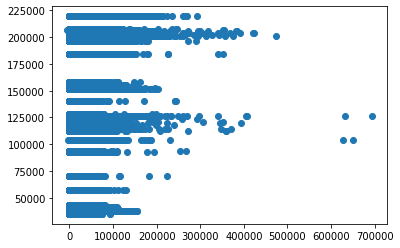

In [136]:
matplotlib.pyplot.scatter(df['Weekly_Sales'], df['Size'])
matplotlib.pyplot.show()

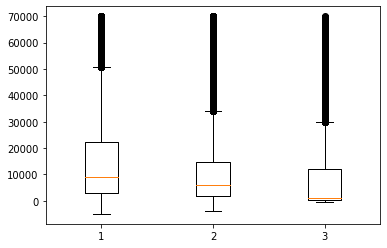

In [6]:
dff = train_df[train_df['Weekly_Sales'] <= 70000]
df_1 = dff['Weekly_Sales'][dff['Type'] == 'A']
df_2 = dff['Weekly_Sales'][dff['Type'] == 'B']
df_3 = dff['Weekly_Sales'][dff['Type'] == 'C']
data = [df_1, df_2, df_3]

matplotlib.pyplot.boxplot(data)
matplotlib.pyplot.show()

In [7]:
# Find stores Type `B` with sales higher than 80 ... 10'th store
gsb = train_df[train_df['Type'] == 'B'].groupby('Store').agg({'Weekly_Sales':'sum'})
gsa = train_df[train_df['Type'] == 'A'].groupby('Store').agg({'Weekly_Sales':'sum'})
print(gsb[gsb['Weekly_Sales'] >= np.percentile(gsa['Weekly_Sales'], 80)])

       Weekly_Sales
Store              
10      200092030.4


In [4]:
# Sales_store_type
sst = train_df.groupby('Store').agg({'Weekly_Sales':'sum'})
sst['Total_Sales_Store_Type'] = ''

for i in range(0,45):
    if sst.iloc[i,0] >= np.percentile(sst['Weekly_Sales'], 80):
        sst.iloc[i,1] = 5
    elif sst.iloc[i,0] >= np.percentile(sst['Weekly_Sales'], 60):
        sst.iloc[i,1] = 4
    elif sst.iloc[i,0] >= np.percentile(sst['Weekly_Sales'], 40):
        sst.iloc[i,1] = 3
    elif sst.iloc[i,0] >= np.percentile(sst['Weekly_Sales'], 20):
        sst.iloc[i,1] = 2
    else:
        sst.iloc[i,1] = 1

# applied to all df
train_df['Total_Sales_Store_Type'] = train_df['Store'].apply(lambda x: sst['Total_Sales_Store_Type'][x])
test_df['Total_Sales_Store_Type'] = test_df['Store'].apply(lambda x: sst['Total_Sales_Store_Type'][x])

# counted number of each store's type, all types by 9 stores
sst.groupby('Total_Sales_Store_Type').count() 

,Weekly_Sales
Total_Sales_Store_Type,
1,9
2,9
3,9
4,9
5,9


In [9]:
# Counted number of holidays in train and test set (8 in train and 2 in test)
ih = train_df.groupby('Date').agg({'IsHoliday_x':'sum'})
print('Number of holidays in train set - ', len(ih[ih['IsHoliday_x'] != 0]))
tih = test_df.groupby('Date').agg({'IsHoliday_x':'sum'})
print('Number of holidays in test set - ', len(tih[tih['IsHoliday_x'] != 0]))

Number of holidays in train set -  8
Number of holidays in test set -  2


In [10]:
ih[ih['IsHoliday_x'] != 0]

,IsHoliday_x
Date,
2010-02-12,2956.0
2010-09-10,2937.0
2010-11-26,2938.0
2010-12-31,2943.0
2011-02-11,2938.0
2011-09-09,2958.0
2011-11-25,3021.0
2011-12-30,3003.0


In [11]:
# Commented because it takes a lot of time
supbow = 6
blackfr = 47
christ = 52
df['Is_SuperBowl'] = df['Week'].apply(lambda x: 1 if x == supbow else 0)
df['Is_BlackFriday'] = df['Week'].apply(lambda x: 1 if x == blackfr else 0)
df['Is_Christmas'] = df['Week'].apply(lambda x: 1 if x == christ else 0)
df['Regular_weeks'] = df['IsHoliday_x'].apply(lambda x: 1 if x == False else 0)
df['Other_holidays'] = ''
for i in df.index:
    if df.loc[i,'Is_SuperBowl'] == 0 and df.loc[i,'Is_BlackFriday'] == 0 and df.loc[i,'Is_Christmas'] == 0 and df.loc[i,'Regular_weeks'] == 0:
        df.loc[i,'Other_holidays'] = 1
    else:
        df.loc[i,'Other_holidays'] = 0    

In [12]:
#df.to_csv('our_train.csv')

In [13]:
#df = pd.read_csv('our_train.csv', index_col = 0)

In [14]:
# There is 3 other holidays in whole train set
oh = df.groupby('Date').agg({'Other_holidays':'sum'})
oh[oh['Other_holidays'] != 0]

,Other_holidays
Date,
2010-09-10,2937
2011-09-09,2958
2012-09-07,2966


In [15]:
# Percent of sales in different holidays (3, 2, 2) Highest
per = df[df['Year'] == 2011]

stors_sals = per.groupby('Store').agg({'Weekly_Sales':'sum'}).sort_values(by = 'Weekly_Sales', ascending = False)[1:10]
print('Top 10 highest sales stores')

bf = per[per['Is_BlackFriday'] == 1].groupby('Store').agg({'Weekly_Sales':'sum'})
print('% of sales in Black Friday - ', round((bf.loc[stors_sals.index.tolist()]['Weekly_Sales'].sum() / 
                                              stors_sals['Weekly_Sales'].sum()) * 100, 0))

sb = per[per['Is_SuperBowl'] == 1].groupby('Store').agg({'Weekly_Sales':'sum'})
print('% of sales in Super Bowl - ', round((sb.loc[stors_sals.index.tolist()]['Weekly_Sales'].sum() / 
                                              stors_sals['Weekly_Sales'].sum()) * 100, 0))

ch = per[per['Is_Christmas'] == 1].groupby('Store').agg({'Weekly_Sales':'sum'})
print('% of sales Christmas - ', round((ch.loc[stors_sals.index.tolist()]['Weekly_Sales'].sum() / 
                                              stors_sals['Weekly_Sales'].sum()) * 100, 0))


Top 10 highest sales stores
% of sales in Black Friday -  3.0
% of sales in Super Bowl -  2.0
% of sales Christmas -  2.0


In [16]:
# Percent of sales in different holidays (2, 2, 2) Lowest
per = df[df['Year'] == 2011]

stors_sals = per.groupby('Store').agg({'Weekly_Sales':'sum'}).sort_values(by = 'Weekly_Sales')[1:10]
print('Top 10 lowest sales stores')

bf = per[per['Is_BlackFriday'] == 1].groupby('Store').agg({'Weekly_Sales':'sum'})
print('% of sales in Black Friday - ', round((bf.loc[stors_sals.index.tolist()]['Weekly_Sales'].sum() / 
                                              stors_sals['Weekly_Sales'].sum()) * 100, 0))

sb = per[per['Is_SuperBowl'] == 1].groupby('Store').agg({'Weekly_Sales':'sum'})
print('% of sales in Super Bowl - ', round((sb.loc[stors_sals.index.tolist()]['Weekly_Sales'].sum() / 
                                              stors_sals['Weekly_Sales'].sum()) * 100, 0))

ch = per[per['Is_Christmas'] == 1].groupby('Store').agg({'Weekly_Sales':'sum'})
print('% of sales Christmas - ', round((ch.loc[stors_sals.index.tolist()]['Weekly_Sales'].sum() / 
                                              stors_sals['Weekly_Sales'].sum()) * 100, 0))

Top 10 lowest sales stores
% of sales in Black Friday -  2.0
% of sales in Super Bowl -  2.0
% of sales Christmas -  2.0


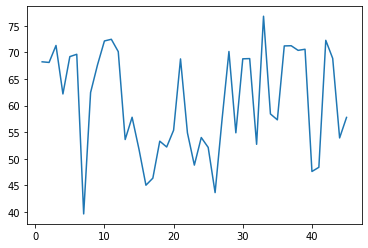

In [17]:
# Temperature
temp = df.groupby('Store').agg({'Temperature':'mean'})

matplotlib.pyplot.plot(temp)
matplotlib.pyplot.show()

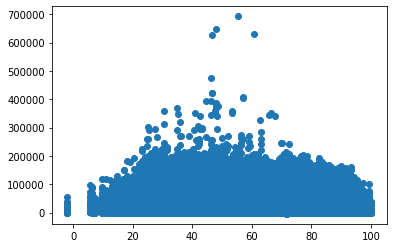

In [18]:
matplotlib.pyplot.scatter(train_df['Temperature'], train_df['Weekly_Sales'])
matplotlib.pyplot.show()

In [19]:
round(train_df['Weekly_Sales'].corr(train_df['Temperature']), 3)

-0.004

In [20]:
# Stores with the biggest difference - 7 and 33
t = df[(df['Year'] == 2010)&(df['Week'] >= 26)&(df['Week'] <= 30)].groupby('Store').agg({'Temperature':'mean'}) 
print(t[t['Temperature']== t['Temperature'].min()])
print(t[t['Temperature']== t['Temperature'].max()])

       Temperature
Store             
7        62.443491
       Temperature
Store             
33       96.671743


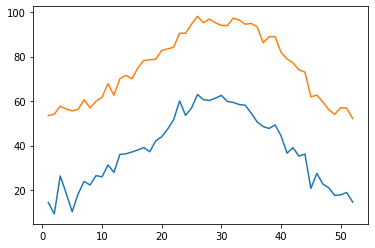

In [142]:
st7 = df[df['Store'] == 7]
gr7 = st7.groupby('Week').agg({'Temperature':'mean'})
st33 = df[df['Store'] == 33]
gr33 = st33.groupby('Week').agg({'Temperature':'mean'})
grs = gr7.merge(gr33, left_index = True, right_index=True)
matplotlib.pyplot.plot(grs)
matplotlib.pyplot.show()

In [143]:
print(round(train_df['Weekly_Sales'][df['Store'] == 7].corr(train_df['Temperature'][df['Store'] == 7]), 3))
print(round(train_df['Weekly_Sales'][df['Store'] == 33].corr(train_df['Temperature'][df['Store'] == 33]), 3))

-0.012
-0.003


In [21]:
#Average month temperature for every store

tg = train_df.groupby(['Year_Month','Store']).agg({'Temperature':'mean'})

train_df['Average_Temperature_month'] = ''
for i in train_df.index:
    train_df['Average_Temperature_month'][i] = float(tg.loc[(train_df['Year_Month'][i], train_df['Store'][i])])

#train_df.to_csv('train_df.csv')

In [137]:
#train_df = pd.read_csv('train_df.csv', index_col = 0)

In [23]:
tg = test_df.groupby(['Year_Month','Store']).agg({'Temperature':'mean'})

test_df['Average_Temperature_month'] = ''
for i in test_df.index:
    test_df['Average_Temperature_month'][i] = float(tg.loc[(test_df['Year_Month'][i], test_df['Store'][i])])
test_df['Month'] = test_df['Date'].apply(lambda x: x.split('-')[1])
#test_df.to_csv('test_df.csv')


In [72]:
#test_df = pd.read_csv('test_df.csv', index_col = 0)

In [74]:
cols = ['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Temperature', 'Date']

In [75]:
# Delete needless columns
train_df = train_df.drop(columns = cols)
train_df = train_df.drop(columns = ['IsHoliday_x', 'IsHoliday_y', 'Type', 'Year_Month'])

In [76]:
test_df = test_df.drop(columns = cols)
test_df = test_df.drop(columns = ['IsHoliday_x', 'IsHoliday_y', 'Type', 'Year_Month'])

In [77]:
holdays = df.iloc[:,-5:]
train_df = train_df.merge(holdays, left_index = True, right_index=True)
test_df = test_df.merge(holdays, left_index = True, right_index=True)

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing


col = 'Weekly_Sales'
y_train = train_df[col]
x_train = train_df.drop(columns = col)
y_test = test_df[col]
x_test = test_df.drop(columns = col)

clf = RandomForestRegressor(n_estimators = 10, max_depth = 10)
clf.fit(x_train, y_train, sample_weight=x_train['Sample Weight'])

train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)
print('MAE on train : ', round(mean_absolute_error(y_train, train_pred, sample_weight=x_train['Sample Weight']), 3), 
      ', MAE on test : ', round(mean_absolute_error(y_test, test_pred, sample_weight=x_test['Sample Weight']), 3))

MAE on train :  4499.893 , MAE on test :  4661.706


In [ ]:
# Grid Search

max_features = []
i = 0
while i <= 0.9:
    i += 0.1
    max_features.append(round(i,1))
results = []
for n_est in range(5,50,2):
    for max_fea in max_features:
        for max_dep in range(2, 20, 1):
            clf = RandomForestRegressor(n_estimators = n_est, max_features = max_fea, max_depth = max_dep)
            clf.fit(x_train, y_train, sample_weight=x_train['Sample Weight'])
            test_pred = clf.predict(x_test)
            print(n_est, max_fea, max_dep, round(mean_absolute_error(y_test, test_pred, sample_weight=x_test['Sample Weight']), 3))
            results.append([n_est, max_fea, max_dep, round(mean_absolute_error(y_test, test_pred, sample_weight=x_test['Sample Weight']), 3)])
print('###################################')
print(results)

rdf = pd.DataFrame(results)
#rdf

In [35]:
rdf['3'].min()

2649.103

In [36]:
rdf[rdf['3'] == 2649.103]

,0,1,2,3
3203,39,0.8,19,2649.103


In [78]:
# Build a model with the best parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing


col = 'Weekly_Sales'
y_train = train_df[col]
x_train = train_df.drop(columns = col)
y_test = test_df[col]
x_test = test_df.drop(columns = col)

clf = RandomForestRegressor(n_estimators = 39, max_features = 0.8, max_depth = 19)
clf.fit(x_train, y_train, sample_weight=x_train['Sample Weight'])

train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)
print('MAE on train : ', round(mean_absolute_error(y_train, train_pred, sample_weight=x_train['Sample Weight']), 3), 
      ', MAE on test : ', round(mean_absolute_error(y_test, test_pred, sample_weight=x_test['Sample Weight']), 3))

MAE on train :  967.615 , MAE on test :  2761.226


In [80]:
# Save predictions of the best model

Train_Predictions = pd.DataFrame(train_pred)
Train_Predictions.to_csv('Train_Predictions.csv')

Test_Predictions = pd.DataFrame(test_pred)
Test_Predictions.to_csv('Test_Predictions.csv')

# Difference between default model od our best is 1975.053

MAE for Sales Store Type 1 = 1055.016
MAE for Sales Store Type 2 = 1803.788
MAE for Sales Store Type 3 = 2425.515
MAE for Sales Store Type 4 = 3328.194
MAE for Sales Store Type 5 = 4788.701


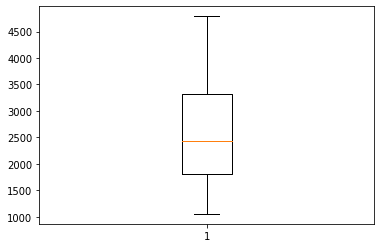

In [116]:
# MAE for different sales store types

train_df1 = train_df.merge(Train_Predictions, left_index = True, right_index=True)
train_df1 = train_df1.rename(columns = {0:'Predicted'}) 

Test_Predictions.index = test_df.index
test_df1 = test_df.merge(Test_Predictions, left_index = True, right_index=True)
test_df1 = test_df1.rename(columns = {0:'Predicted'})

mast = []
for types in range(1,6):
    print('MAE for Sales Store Type', types, '=', 
         round(mean_absolute_error(test_df1['Weekly_Sales'][test_df1['Total_Sales_Store_Type'] == types], 
                                   test_df1['Predicted'][test_df1['Total_Sales_Store_Type'] == types]), 3))
    mast.append([types, round(mean_absolute_error(test_df1['Weekly_Sales'][test_df1['Total_Sales_Store_Type'] == types], 
                                   test_df1['Predicted'][test_df1['Total_Sales_Store_Type'] == types]), 3)])

mast = pd.DataFrame(mast, columns = ['Sales Store Type', 'MAE'])
matplotlib.pyplot.boxplot(mast['MAE'])
matplotlib.pyplot.show()

MAE for Department Type 1 = 4973.302
MAE for Department Type 2 = 2483.166
MAE for Department Type 3 = 14278.115


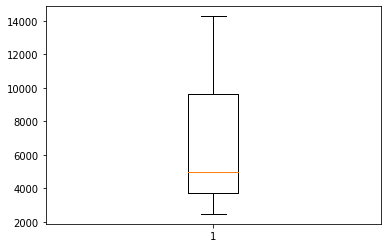

In [121]:
# MAE for different department types

mast = []
for types in range(1,4):
    print('MAE for Department Type', types, '=', 
         round(mean_absolute_error(test_df1['Weekly_Sales'][test_df1['Department_Type'] == types], 
                                   test_df1['Predicted'][test_df1['Department_Type'] == types]), 3))
    mast.append([types, round(mean_absolute_error(test_df1['Weekly_Sales'][test_df1['Department_Type'] == types], 
                                   test_df1['Predicted'][test_df1['Department_Type'] == types]), 3)])

mast = pd.DataFrame(mast, columns = ['Department_Type', 'MAE'])
matplotlib.pyplot.boxplot(mast['MAE'])
matplotlib.pyplot.show()